# Data Preparation
Pipeline: Raw Text → Data Preprocessing → Model Training → Evaluation → Results

## Setup

In [ ]:
import nltk
from nltk.corpus import brown
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Data Discovery

Load Dataset

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')
tagged_sents = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [ ]:
print(tagged_sents[0])

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


Flatten all sentences into a list of (word, tag) tuples

In [ ]:
data = [(word, tag) for sent in tagged_sents for word, tag in sent]

Convert data array into pandas dataframe

In [ ]:
df = pd.DataFrame(data, columns=['word', 'tag'])

In [ ]:
df.head()

,word,tag
0,The,DET
1,Fulton,NOUN
2,County,NOUN
3,Grand,ADJ
4,Jury,NOUN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161192 entries, 0 to 1161191
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   word    1161192 non-null  object
 1   tag     1161192 non-null  object
dtypes: object(2)
memory usage: 17.7+ MB


In [ ]:
df['tag'].unique()

array(['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT',
       'PRON', 'NUM', 'X'], dtype=object)

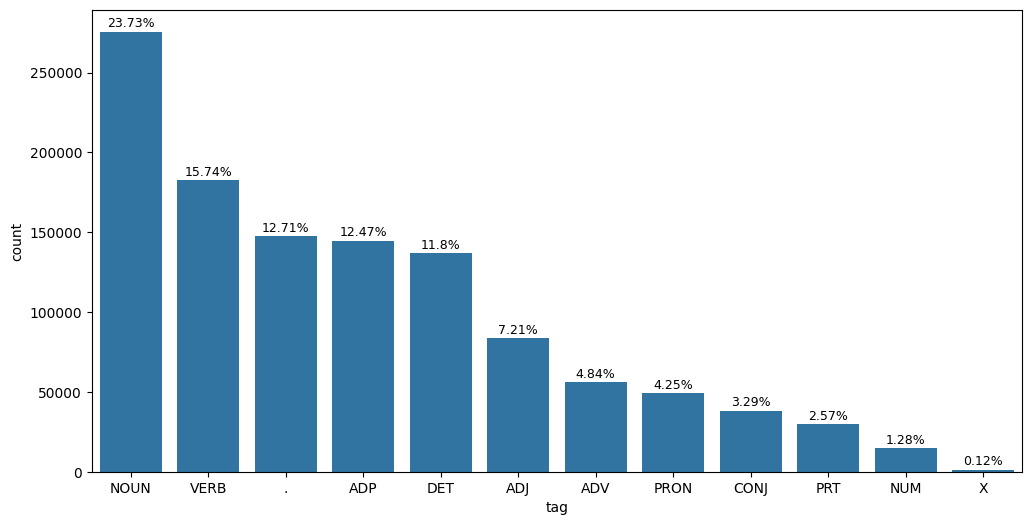

In [ ]:
tag_counts = df['tag'].value_counts()
tag_percentages = (tag_counts / len(df) * 100).round(2)

plt.figure(figsize=(12, 6))
ax = sns.countplot(df, x='tag', order=df['tag'].value_counts().index)

for i, (count, pct) in enumerate(zip(tag_counts.values, tag_percentages.values)):
    ax.text(i, count + 1000, f'{pct}%', ha='center', va='bottom', fontsize=9)

# Data Preprocessing

There will be no feature engineering for BiLSTM, but we still have to ensure sentences are whole:

- `word`: the current word

- `tag`: the label

## Train test split (Split by sentence)

In [ ]:
np.random.seed(42)
n = len(tagged_sents)
indices = np.random.permutation(n)

train_size = int(0.8 * n)
val_size = int(0.1 * n)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[val_size+train_size:]

train_sents = [tagged_sents[i] for i in train_idx]
val_sents = [tagged_sents[i] for i in val_idx]
test_sents = [tagged_sents[i] for i in test_idx]

print(f"\nDataset split:")
print(f"  Train: {len(train_sents):,} sentences")
print(f"  Val:   {len(val_sents):,} sentences")
print(f"  Test:  {len(test_sents):,} sentences")


Dataset split:
  Train: 45,872 sentences
  Val:   5,734 sentences
  Test:  5,734 sentences


In [ ]:
print(f"Sample training sentence: {train_sents[0]}")
print(f"Sample test sentence: {test_sents[0]}")
print(f"Sample test tags: {val_sents[0]}")

Sample training sentence: [('Open', 'ADJ'), ('market', 'NOUN'), ('policy', 'NOUN')]
Sample test sentence: [('Even', 'ADV'), ('the', 'DET'), ('officer', 'NOUN'), ('in', 'ADP'), ('charge', 'NOUN'), (',', '.'), ('be', 'VERB'), ('it', 'PRON'), ('a', 'DET'), ('captain', 'NOUN'), ('(', '.'), ('for', 'ADP'), ('small', 'ADJ'), ('display', 'NOUN'), (')', '.'), ('or', 'CONJ'), ('a', 'DET'), ('general', 'NOUN'), (',', '.'), ('is', 'VERB'), ('restrained', 'VERB'), ('by', 'ADP'), ('monitoring', 'VERB'), ('.', '.')]
Sample test tags: [('Boys', 'NOUN'), ('will', 'VERB'), ('be', 'VERB'), ('boys', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('Texans', 'NOUN'), ('will', 'VERB'), ('be', 'VERB'), ('Texans', 'NOUN'), ('.', '.')]


# Feature Encoding
Index word and tag vocabularies from sentences. This is to map each word into a number. The vocab is built using the train data.

Args:
- `sentences` (list): List of tagged sentences
- `min_freq` (int): Minimum frequency for a word to be included
    
Returns:
- tuple: (word2idx, tag2idx, idx2word, idx2tag)

In [ ]:
from collections import Counter

In [ ]:
def build_vocabularies(sentences, min_freq=2):

    # Count word frequencies
    word_counter = Counter()
    tag_counter = Counter()

    for sent in sentences:
        for word, tag in sent:
            word_counter[word.lower()] += 1
            tag_counter[tag] += 1

    # Build word vocabulary (only words with freq >= min_freq)
    words = ['<PAD>', '<UNK>'] + [w for w, c in word_counter.items() if c >= min_freq]
    word2idx = {w: i for i, w in enumerate(words)}
    idx2word = {i: w for w, i in word2idx.items()}

    # Build tag vocabulary
    tags = ['<PAD>'] + sorted(tag_counter.keys())
    tag2idx = {t: i for i, t in enumerate(tags)}
    idx2tag = {i: t for t, i in tag2idx.items()}

    return word2idx, tag2idx, idx2word, idx2tag

In [ ]:
word2idx, tag2idx, idx2word, idx2tag = build_vocabularies(train_sents)
print(f"Vocabulary size: {len(word2idx)}")
print(f"Number of POS tags: {len(tag2idx)}")
print(f"POS tags: {list(tag2idx.keys())}")

Vocabulary size: 24716
Number of POS tags: 13
POS tags: ['<PAD>', '.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


## Encoding Sentences
Convert sentences to numerical indices and pad them. This function uses the vocab dictionary we built earlier to encode the tagged sentences. Words that do not exist in the vocab dictionary appear as 'UNK', while padding is to ensure all sequences in a batch have the same shape. (The NN will not be able to process batches with irregular shape)
    
Args:
- `sentences` (list): List of tagged sentences
- `word2idx` (dict): Word to index mapping
- `tag2idx` (dict): Tag to index mapping
- `max_len` (int): Maximum sequence length (computed if None)
    
Returns:
- tuple: (word_indices, tag_indices, sequence_lengths, max_len)

In [ ]:
def encode_sentences(sentences, word2idx, tag2idx, max_len=None):

    # Find max length if not provided
    if max_len is None:
        max_len = max(len(sent) for sent in sentences)

    word_indices = []
    tag_indices = []
    seq_lengths = []

    for sent in sentences:
        # Get original length
        seq_len = len(sent)
        seq_lengths.append(seq_len)

        # Convert words and tags to indices
        words = [word2idx.get(word.lower(), word2idx['<UNK>']) for word, _ in sent]
        tags = [tag2idx[tag] for _, tag in sent]

        # Pad sequences
        if len(words) < max_len:
            words += [word2idx['<PAD>']] * (max_len - len(words))
            tags += [tag2idx['<PAD>']] * (max_len - len(tags))
        else:
            # Truncate if needed
            words = words[:max_len]
            tags = tags[:max_len]
            seq_lengths[-1] = max_len

        word_indices.append(words)
        tag_indices.append(tags)

    return np.array(word_indices), np.array(tag_indices), np.array(seq_lengths), max_len

Encode all datasets

In [ ]:
train_X, train_y, train_lengths, max_len = encode_sentences(train_sents, word2idx, tag2idx)
val_X, val_y, val_lengths, _ = encode_sentences(val_sents, word2idx, tag2idx, max_len)
test_X, test_y, test_lengths, _ = encode_sentences(test_sents, word2idx, tag2idx, max_len)

In [ ]:
print(f"Max sequence length: {max_len}")
print()
print(f"Training data shape: {train_X.shape}")
print(f"Training labels shape: {train_y.shape}")
print()
print(f"Validation data shape: {val_X.shape}")
print(f"Validation labels shape: {val_y.shape}")
print()
print(f"Test data shape: {test_X.shape}")
print(f"Test labels shape: {test_y.shape}")

Max sequence length: 172

Training data shape: (45872, 172)
Training labels shape: (45872, 172)

Validation data shape: (5734, 172)
Validation labels shape: (5734, 172)

Test data shape: (5734, 172)
Test labels shape: (5734, 172)


## Create dataloaders
Create a PyTorch DataLoader from numpy arrays.

Args:
- `X` (np.array): Input sequences
- `y` (np.array): Target sequences
- `lengths` (np.array): Actual sequence lengths
- `batch_size` (int): Batch size = 64 (common default)
- `shuffle` (bool): Whether to shuffle data
    
Returns:
- `DataLoader`: PyTorch DataLoader object

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def create_dataloader(X, y, lengths, batch_size=64, shuffle=True):

    # Convert to PyTorch tensors
    X_tensor = torch.LongTensor(X)
    y_tensor = torch.LongTensor(y)
    lengths_tensor = torch.LongTensor(lengths)

    # Create dataset
    dataset = TensorDataset(X_tensor, y_tensor, lengths_tensor)

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader


In [ ]:
train_loader = create_dataloader(train_X, train_y, train_lengths, shuffle=True)
val_loader = create_dataloader(val_X, val_y, val_lengths, shuffle=False)
test_loader = create_dataloader(test_X, test_y, test_lengths, shuffle=False)

In [ ]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 717
Number of validation batches: 90
Number of test batches: 90


# Build BiLSTM Model
The model has bidirectional context (looks both forward and backward in the sentence). It is also designed to have long-range dependencies (captures relationships across distant words).

## Model Architecture:
1. Embedding Layer
    - Transforms encoded words into dense vectors
    - Creates a lookup table where each word gets a unique vector, which are trained during backpropagation
    - Input: one-hot encoded words (word indices)
    - Output: 100-dimensional vectors for each word
2. BiLSTM Layers (2 layers)
    - Captures sequential patterns and bidirectional context (the brain layer)
    - Addresses lexical ambiguity in the English language
    - Input: Word embeddings
    - Output: 256-dimensional hidden states for each word (128 x 2 bidirectional = 256)
3. Dropout Layer (Only Active for training)
    - Prevents overfitting by randomly dropping neurons during training
    - Helps the model generalize better by learning patterns and not noise
4. Fully Connected Layer
    - Transforms BiLSTM hidden states into tag scores
    - Maps LSTM features to tags
    - Input: Hidden states
    - Output: Tag scores (for each word -> 13 scores)
5. Output Layer (Softmax)
    - Converts scores into probabilities
    - Input: Tag scores
    - Output: All tag probabilities for each word

Args:
- `vocab_size` (int): Size of vocabulary
- `embedding_dim` (int): Dimension of word embeddings
- `hidden_dim` (int): Dimension of LSTM hidden state
- `output_size` (int): Number of output tags
- `num_layers` (int): Number of LSTM layers
- `dropout` (float): Dropout probability
    
Returns:
- `nn.Module`: PyTorch model


In [ ]:
import torch.nn as nn

In [ ]:
def create_bilstm_model(vocab_size, embedding_dim, hidden_dim, output_size,
                        num_layers=2, dropout=0.3):

    model = nn.Sequential()

    class BiLSTM(nn.Module):
        def __init__(self):
            super(BiLSTM, self).__init__()

            # Embedding layer
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

            # BiLSTM layer
            self.lstm = nn.LSTM(
                embedding_dim,
                hidden_dim,
                num_layers=num_layers,
                bidirectional=True,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )

            # Dropout layer
            self.dropout = nn.Dropout(dropout)

            # Output layer (hidden_dim * 2 because bidirectional)
            self.fc = nn.Linear(hidden_dim * 2, output_size)

        def forward(self, x, lengths):
            # x shape: (batch_size, seq_len)
            # lengths shape: (batch_size)
            batch_size, seq_len = x.size()
            # Embedding: (batch_size, seq_len, embedding_dim)
            embedded = self.embedding(x)

            # Pack padded sequence for efficient processing
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
            )

            # BiLSTM: (batch_size, seq_len, hidden_dim * 2)
            lstm_out, _ = self.lstm(packed)

            # Unpack sequence
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
                lstm_out,
                batch_first=True,
                total_length=seq_len)

            # Apply dropout
            lstm_out = self.dropout(lstm_out)

            # Output projection: (batch_size, seq_len, output_size)
            output = self.fc(lstm_out)

            return output

    return BiLSTM()

# Model hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.3

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_bilstm_model(
    vocab_size=len(word2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_size=len(tag2idx),
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

In [ ]:
print(f"Device: {device}")
print(f"Model Architecture:\n{model}")
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters())}")

Device: cpu
Model Architecture:
BiLSTM(
  (embedding): Embedding(24716, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=13, bias=True)
)

Total Parameters: 3105725


# Training and Evaluation

## Loss function and optimizer setup
- `criterion`: Cross Entropy Loss function with ignore_index for padding (ignore 'PAD' tokens)
- `optimizer`: Adam optimizer with 0.001 learning rate

In [ ]:
import torch.optim as optim

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model for one epoch

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):

    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    for batch_idx, (inputs, targets, lengths) in enumerate(dataloader):
        # Move to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        lengths = lengths.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, lengths)  # (batch_size, seq_len, num_tags)

        # Reshape for loss calculation
        outputs_flat = outputs.view(-1, outputs.shape[-1])  # (batch_size * seq_len, num_tags)
        targets_flat = targets.view(-1)  # (batch_size * seq_len)

        # Calculate loss
        loss = criterion(outputs_flat, targets_flat)

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        # Update weights
        optimizer.step()

        # Calculate accuracy (excluding padding)
        predictions = outputs.argmax(dim=-1)  # (batch_size, seq_len)
        mask = targets != tag2idx['<PAD>']  # Create mask for non-padding tokens

        correct = (predictions == targets) & mask
        total_correct += correct.sum().item()
        total_tokens += mask.sum().item()
        total_loss += loss.item()

        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_tokens

    return avg_loss, accuracy

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Evaluate the model on a dataset

In [ ]:
def evaluate(model, dataloader, criterion, device):

    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets, lengths in dataloader:
            # Move to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            lengths = lengths.to(device)

            # Forward pass
            outputs = model(inputs, lengths)

            # Calculate loss
            outputs_flat = outputs.view(-1, outputs.shape[-1])
            targets_flat = targets.view(-1)
            loss = criterion(outputs_flat, targets_flat)
            total_loss += loss.item()

            # Get predictions
            predictions = outputs.argmax(dim=-1)

            # Store predictions and targets (excluding padding)
            for i in range(len(inputs)):
                seq_len = lengths[i].item()
                pred_seq = predictions[i, :seq_len].cpu().numpy()
                target_seq = targets[i, :seq_len].cpu().numpy()

                all_predictions.extend(pred_seq)
                all_targets.extend(target_seq)

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_targets, all_predictions)

    return avg_loss, accuracy, all_predictions, all_targets

Train model on specified epochs

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Validate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"  → New best validation accuracy: {best_val_acc:.4f}")

    return history


Train the model

In [ ]:
import time

In [ ]:
training_start = time.perf_counter()
history = train_model(model, train_loader, val_loader, criterion, optimizer, device)
training_end = time.perf_counter()


Epoch 1/10
--------------------------------------------------
  Batch 100/717, Loss: 0.6550
  Batch 200/717, Loss: 0.4209
  Batch 300/717, Loss: 0.3611
  Batch 400/717, Loss: 0.2586
  Batch 500/717, Loss: 0.2778
  Batch 600/717, Loss: 0.2416
  Batch 700/717, Loss: 0.2398
Train Loss: 0.4641, Train Acc: 0.8471
Val Loss: 0.1891, Val Acc: 0.9371
  → New best validation accuracy: 0.9371

Epoch 2/10
--------------------------------------------------
  Batch 100/717, Loss: 0.1581
  Batch 200/717, Loss: 0.1802
  Batch 300/717, Loss: 0.1430
  Batch 400/717, Loss: 0.1625
  Batch 500/717, Loss: 0.1554
  Batch 600/717, Loss: 0.1468
  Batch 700/717, Loss: 0.1299
Train Loss: 0.1690, Train Acc: 0.9447
Val Loss: 0.1229, Val Acc: 0.9595
  → New best validation accuracy: 0.9595

Epoch 3/10
--------------------------------------------------
  Batch 100/717, Loss: 0.1065
  Batch 200/717, Loss: 0.1078
  Batch 300/717, Loss: 0.1089
  Batch 400/717, Loss: 0.0992
  Batch 500/717, Loss: 0.1244
  Batch 600/717

Classification Report

In [ ]:
inference_start = time.perf_counter()
test_loss, test_acc, test_predictions, test_targets = evaluate(model, test_loader, criterion, device)
inference_end = time.perf_counter()

print(f"Training time: {training_end - training_start:.4f}s")
print(f"Inference time: {inference_end - inference_start:.4f}s")

Training time: 4215.5727s
Inference time: 6.7825s


In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0908
Test Accuracy: 0.9737


In [ ]:
tag_names = [tag for tag in sorted(tag2idx.keys()) if tag != '<PAD>'] # exclude padding
print(classification_report(test_targets, test_predictions,
                               target_names=tag_names,
                               labels=[tag2idx[tag] for tag in tag_names],
                               zero_division=0))

              precision    recall  f1-score   support

           .       1.00      1.00      1.00     14971
         ADJ       0.90      0.94      0.92      8585
         ADP       0.98      0.99      0.98     14891
         ADV       0.96      0.93      0.94      5716
        CONJ       0.99      1.00      1.00      3942
         DET       0.99      1.00      1.00     14006
        NOUN       0.97      0.97      0.97     28214
         NUM       0.97      0.90      0.93      1598
        PRON       0.99      0.99      0.99      5081
         PRT       0.95      0.95      0.95      3045
        VERB       0.98      0.97      0.97     18733
           X       0.63      0.54      0.58       126

    accuracy                           0.97    118908
   macro avg       0.94      0.93      0.94    118908
weighted avg       0.97      0.97      0.97    118908



Confusion Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

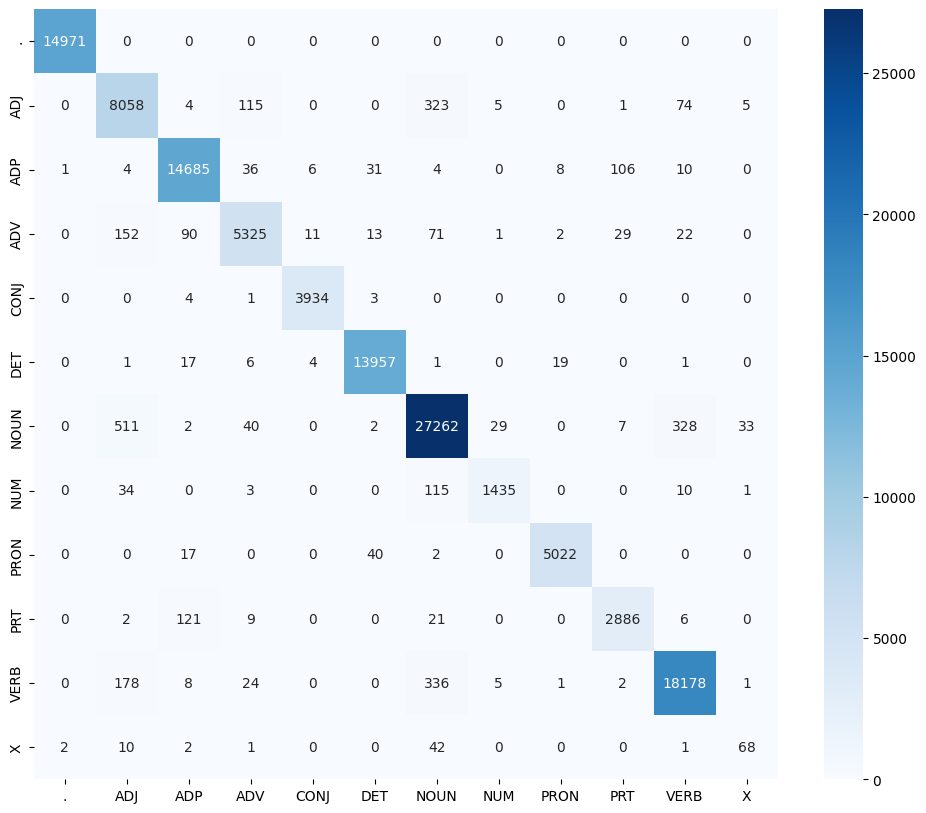

In [ ]:
cm = confusion_matrix(test_targets, test_predictions, labels=[tag2idx[tag] for tag in tag_names])
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tag_names, yticklabels=tag_names)
plt.show()

Training and validation metrics

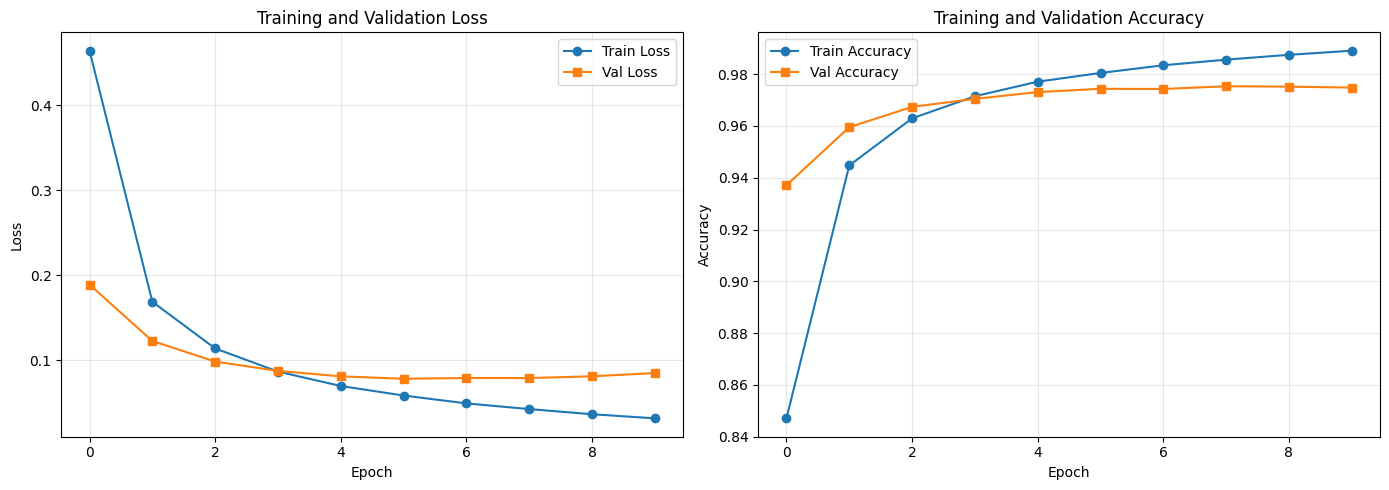

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()